In [ ]:
#from google.colab import drive 
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
from keras import backend as K
K.clear_session()

C:\Users\maruf\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
#Importing all the libraries needed
import keras
import tensorflow
import h5py
from keras import optimizers, preprocessing, Input
from keras.models import load_model, Model
from keras.layers import Bidirectional
from keras.layers.core import Reshape, Dropout
from keras.utils.vis_utils import  plot_model
import os
import itertools
import matplotlib.pyplot as plt
from keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling3D
from keras import regularizers
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.applications.inception_v3 import InceptionV3
import nltk
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.layers import Dense, GlobalAveragePooling2D, Embedding, LSTM, multiply
from PIL import Image, ImageFile
from sklearn.model_selection import train_test_split

C:\Users\maruf\Anaconda3\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
C:\Users\maruf\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\maruf\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence 

In [4]:
# text pre-processing functions
def clean_text(text):
    text = text.replace('\nBULLET::::', ' ')
    text = text.replace('BULLET::::-', ' ')
    text = text.replace('BULLET::::', ' ')
    text = text.replace('\n', ' ')
    text = text.replace('\n\n', ' ')
    text = text.replace(r',', '')
    text = text.replace('.', '')
    text = text.replace(' - ', '')
    text = text.replace('-', '')
    text = text.replace('&nbsp;', ' ')
    text = text.replace('Page', ' ')
    text = text.replace(':', ' ')
    text = text.replace(';', ' ')
    text = text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace('(', '')
    text = text.replace('[', '')
    text = text.replace(']', '')
    text = text.replace(')', '')
    text = text.strip()
    text = re.sub(r'\d+.', ' ', text)
    text = re.sub(r' +', ' ', text)
    return text

def get_tamil_stop_words():
    swdf1 = pd.read_csv("D:\\My Research\SHared Task\\Stopwords\\TamilNLP_TamilStopWords.txt",  header=None) 
    swdf2 = pd.read_csv("D:\\My Research\SHared Task\\Stopwords\\TamilNLP_TamilStopWords.txt",  header=None) 
    sw1 = swdf1[0].tolist()
    sw2 = swdf2[0].tolist()
    tamil_stop_words = list(set(sw1 + sw2))
    return tamil_stop_words

In [5]:
tamil_stop_words = get_tamil_stop_words()

In [6]:
#LSTM Implementation

In [7]:
Training_path = 'D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\train_captions_final.csv'
Testing_path = 'D:\\My Research\\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\test_captions.csv'
Validation_path = 'D:\\My Research\\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\test_captions_final.csv'


In [8]:
def read_data(file_name):
  #Opening file
    with open(file_name,'r', encoding="utf8",newline='\n', errors='ignore') as f:
      #Creating empty set and dictonary for vocab and word respectively
        word_vocab = set() 
        word2vector = {}
        #Iterating over each line of file
        for line in f:
            #Spliting lines
            line_ = line.strip() 
            #Splitting words
            words_Vec = line_.split()            
            word_vocab.add(words_Vec[0])
            word2vector[words_Vec[0]] = np.array(words_Vec[1:],dtype=float)
    print("Total Words in DataSet:",len(word_vocab))
    return word_vocab,word2vector

In [9]:
def encode_label(DataFrame, Label_col):
    t_y = DataFrame[Label_col].values
    Encoder = LabelEncoder()
    y = Encoder.fit_transform(t_y)
    DataFrame[Label_col] = y

In [10]:
def preprocess_text(Training_path,Validation_path, Testing_path):
    # function to preprocess input
    training_DF = pd.read_csv(Training_path, sep = ',')
    validation_DF = pd.read_csv(Validation_path, sep = ',')
    testing_DF = pd.read_csv(Testing_path, sep = ',')

    # encoding all the labels 
    encode_label(testing_DF,'label')
    encode_label(training_DF, 'label')
    encode_label(validation_DF, 'label')
    
    training_DF['sentence'] = training_DF['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (tamil_stop_words)]))      
    validation_DF['sentence'] = validation_DF['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (tamil_stop_words)]))
    testing_DF['sentence'] = testing_DF['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (tamil_stop_words)]))

    # Processing the text
    training_DF['sentence'] = training_DF['sentence'].apply(clean_text)
    testing_DF['sentence'] = testing_DF['sentence'].apply(clean_text)
    validation_DF['sentence'] = validation_DF['sentence'].apply(clean_text)

    return training_DF, testing_DF, validation_DF

In [11]:
#splitting data into train, test and validation
training_df, testing_df, validation_df = preprocess_text(Training_path,Validation_path, Testing_path)

In [12]:
maxlen = 1000
EMBEDDING_DIM = 300

In [13]:
#model with adam optimizer
adam = tensorflow.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adadelta = tensorflow.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.9, epsilon=None, decay=0.0)

C:\Users\maruf\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
# Vectorising text
# process the whole observation into single list
train_text_list= list(training_df['sentence'])
test_text_list = list(testing_df['sentence'])
val_text_list = list(validation_df['sentence'])

# Creating vectors for train, test, validation
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(train_text_list)
sequences_train = tokenizer.texts_to_sequences(train_text_list)
sequences_test = tokenizer.texts_to_sequences(test_text_list)
sequences_val = tokenizer.texts_to_sequences(val_text_list)

x_train = preprocessing.sequence.pad_sequences(sequences_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(sequences_test, maxlen=maxlen)
x_val = preprocessing.sequence.pad_sequences(sequences_val, maxlen=maxlen)


y_test = testing_df['label']
y_train = training_df['label']
y_val = validation_df['label']

In [15]:
def img_text_generator(files, padded_seq, y, batch_size=None):
    """
        padded_seq: vectorized padded text sequence 
        y: label of the text
        batch_size: Number of observations to be selected at a time
        
        return: generator object of text data
    """
    while True:
        batch_idxs = np.random.choice(a = list(range(len(padded_seq))), size=batch_size) #Selecting the random batch indexes    
        batch_input_txt = [] # Initializing batch input text
        batch_input_img = [] # Initializing batch input image
        batch_output = [] # Initializing batch output
        
        # Traversing through the batch indexes
        for batch_idx in batch_idxs:
            input_txt = padded_seq[batch_idx] # selecting padded sequences from the batch
            output = y[batch_idx] # Selecting label  
            input_img = get_input(files[batch_idx])
            input_img = process_input(input_img)
            batch_input_txt.append(input_txt) # Appending the input (text vector)
            batch_input_img.append(input_img[0])
            batch_output.append(output) # Appending the label
        
        # Return a tuple of (input,output) to feed the network
        batch_x1 = np.array( batch_input_img )
        batch_x2 = np.array( batch_input_txt )
        batch_y = np.array( batch_output )
        yield ([batch_x1, batch_x2], batch_y)

In [16]:
def text_generator(padded_seq, y, batch_size=None):
    """
        padded_seq: vectorized padded text sequence 
        y: label of the text
        batch_size: Number of observations to be selected at a time
        
        return: generator object of text data
    """
    idxs = list(range(len(y)))
    idx = 0
    while True:
        batch_idxs = idxs[idx:idx+batch_size]
        idx = idx + batch_size
#         batch_idxs = np.random.choice(a = list(range(len(padded_seq))), size=batch_size) #Selecting the random batch indexes    
        batch_input = [] # Initializing batch input
        batch_output = [] # Initializing batch output
        
        # Traversing through the batch indexes
        for batch_idx in batch_idxs:
            input = padded_seq[batch_idx] # selecting padded sequences from the batch
            output = y[batch_idx] # Selecting label            
            batch_input.append(input) # Appending the input (text vector)
            batch_output.append(output) # Appending the label
        
        # Return a tuple of (input,output) to feed the network
        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        if len(batch_x) < batch_size:
            idx = 0
        else:             
            yield (batch_x, batch_y)

In [17]:
def get_input(path):
    # Loading image from given path
    # and resizing it to 224*224*3 format
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    img = image.load_img(path, target_size=(224,224))    
    return(img)

In [18]:
def get_output(path,label_file=None):
    # Spliting the path and take out the image id    
    filename = path.split('/')[-1]
    # Taking list of labels
    labels = list(label_file[label_file['image_name'] == filename]['label'].values)
  #  for duplicate selecting labels
    if len(labels) <= 2:
        label = labels[0]
    elif len(labels) > 2:
        uni_label = list(set(labels))
        count_label = [labels.count(lab) for lab in uni_label]
        lab_idx = count_label.index(max(count_label))
        label = uni_label[lab_idx]
    #label = labels[0]
    return label

In [19]:
def process_input(img):
    # Converting image to array    
    img_data = image.img_to_array(img)
    # Adding one more dimension to array    
    img_data = np.expand_dims(img_data, axis=0)
    #     
    img_data = preprocess_input(img_data)
    return(img_data)

In [20]:
 
# Creating train, test, val, generator for text
txt_gen_train = text_generator(x_train, y_train, batch_size=32)
txt_gen_test = text_generator(x_test, y_test, batch_size=1)
txt_gen_val = text_generator(x_val, y_val, batch_size=1)

# text_generator() Return a tuple of (padded sequences array,label array) to feed the network



In [21]:
# https://towardsdatascience.com/implementing-neural-machine-translation-using-keras-8312e4844eb8

In [22]:
# nice reading blog for this implementation


In [23]:
# from gensim.models import KeyedVectors
# model_ft = KeyedVectors.load_word2vec_format("D:\\My Research\\SHared Task\\cc.ta.300.vec")

In [24]:
# #embedding weight matrix

# embedding_matrix_1 = np.zeros((num_tokens + 1, EMBEDDING_DIM))

# count = 0 ;

# for word,i in word_index.items():

#     try:
#         embedding_matrix_1[i] = np.array(model_ft[word])
#         count = count + 1;  
#     except Exception:
#         ;

# print(count);
# print(embedding_matrix_1.shape)

In [25]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

# LSTM 

embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(10000, embedding_vecor_length, input_length=1000))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f1_m])
print(model.summary())

subdir = "D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\";
filepath = os.path.join(subdir,"weights_best.hdf5") 
checkpoint = ModelCheckpoint(filepath, monitor= "val_f1_m" , verbose=1, save_best_only=True, mode='max',save_weights_only=True)

callbacks_list = [checkpoint]

model.fit(x_train, y_train, epochs=10, batch_size=32,verbose = 1 , callbacks = callbacks_list, validation_data=(x_val,y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 32)          320000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 373,301
Trainable params: 373,301
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
51/51 [==============================] - ETA: 0s - loss: 0.6341 - f1_m: 0.7447
Epoch 00001: val_f1_m improved from -inf to 0.41536, saving model to D:\My Research\SHared Task\Troll Meme\Tamil_troll_memes\tamil_memes_modified_Nusrat\weights_best.hdf5
51/51 [==============================] - 209s 4s

In [26]:
#predicting the labels for the test set
y_pred_txt = (model.predict_generator(txt_gen_test, steps=667))
y_pred_txt = np.round(list(itertools.chain(*y_pred_txt)))

y_pred_txt



#true labels
#y_true = y_test.values
#y_true

C:\Users\maruf\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


array([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
       1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
       1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1.,
       0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0.,
       1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
       0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
       0., 0., 0., 0., 1.

In [27]:
# y_pred_txt = [ int(x) for x in y_pred_txt ]

In [28]:
# print(y_test.values[:10])

In [29]:
# only_text_df = pd.read_csv('D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\submit1.csv')

In [30]:
# y_pred_txt

In [31]:
# count = 0;
# for i in y_pred_txt:
#     if i == 1:
#       only_text_df['label'][count] = i;
#     count = count + 1;

In [32]:
# only_text_df['label'][0]

In [33]:
# only_text_df.head()

In [34]:
# count = 0;
# for i in y_pred_txt:
#     if i == 1:
#       only_text_df['label'][count] = "troll";
#     else:
#         only_text_df['label'][count] = "not_troll";
#     count = count + 1;
# count

In [35]:
#only_text_df.head()

In [36]:
#only_text_df.to_csv('D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\my_submit1.csv')

In [37]:
# Final evaluation of the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(10000, embedding_vecor_length, input_length=1000))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.load_weights(filepath)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])
scores = model.evaluate(x_test, y_test, verbose=1,batch_size = 32)
print("Accuracy : %.2f%%" % (scores[1]*100))

21/21 [==============================] - 5s 200ms/step - loss: 2.7887 - f1_m: 0.6931
Accuracy : 69.31%


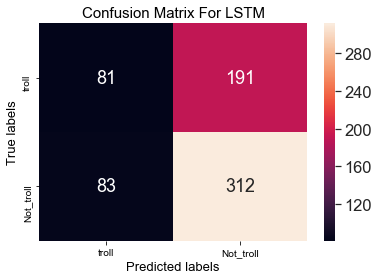

In [40]:

from sklearn.metrics import classification_report, confusion_matrix
import itertools

labels = ['troll', 'Not_troll']
cm = confusion_matrix(y_test, y_pred_txt)

ax= plt.subplot()
sns.set(font_scale=1.5) # Adjust to fit
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
label_font = {'size':'13'}  # Adjust to fit
ax.set_xlabel('Predicted labels',fontdict=label_font);
ax.set_ylabel('True labels',fontdict=label_font); 

title_font = {'size':'15'}  # Adjust to fit

ax.set_title('Confusion Matrix For LSTM',fontdict=title_font); 

ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit
ax.xaxis.set_ticklabels(['troll', 'Not_troll']); 
ax.yaxis.set_ticklabels(['troll', 'Not_troll']);

plt.savefig('D:\\My Research\\Shared Task Paper\\Troll\\Images\\confusion_matrix_LSTM_Text.jpg')  

In [43]:
print('Classification Report')
target_names = ['troll', 'Not_troll']
print(classification_report(y_test, y_pred_txt, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       troll       0.49      0.30      0.37       272
   Not_troll       0.62      0.79      0.69       395

   micro avg       0.59      0.59      0.59       667
   macro avg       0.56      0.54      0.53       667
weighted avg       0.57      0.59      0.56       667



In [44]:
# CNN+LSTM create the model

embedding_vecor_length = 32
model1 = Sequential()
model1.add(Embedding(10000, embedding_vecor_length, input_length=1000))
model1.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(LSTM(100))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])
print(model1.summary())

subdir = "D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\";
filepath = os.path.join(subdir,"weights_best_cnn.hdf5") 

checkpoint = ModelCheckpoint(filepath, monitor='val_f1_m', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
callbacks_list = [checkpoint]


model1.fit(x_train, y_train, epochs=15, batch_size=32,verbose = 1 , callbacks = callbacks_list, validation_data=(x_val,y_val))


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 32)          320000    
                                                                 
 conv1d (Conv1D)             (None, 1000, 32)          3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 32)          0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 100)               53200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 376,405
Trainable params: 376,405
Non-trainable params: 0
________________________________________________

In [53]:

import os         # Creating a directory
model.save('D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\CNN_LSTM_Text_model.h5')   # Saving model

In [45]:
#predicting the labels for the test set
y_pred_txt = (model1.predict_generator(txt_gen_test, steps=667))
y_pred_txt = np.round(list(itertools.chain(*y_pred_txt)))

y_pred_txt



C:\Users\maruf\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


array([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1.,
       1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0.,
       1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
       0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1.,
       1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
       1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 1., 1.

In [55]:
# y_pred_txt = [ int(x) for x in y_pred_txt ]

In [56]:
# only_text_df = pd.read_csv('D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\submit1.csv')

In [57]:
# count = 0;
# for i in y_pred_txt:
#     if i == 1:
#       only_text_df['label'][count] = "troll";
#     else:
#         only_text_df['label'][count] = "not_troll";
#     count = count + 1;
# count

663

In [58]:
# only_text_df.to_csv('D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\my_submit2_txt.csv')

In [46]:
# Final evaluation of the model

embedding_vecor_length = 32
model1 = Sequential()
model1.add(Embedding(10000, embedding_vecor_length, input_length=1000))
model1.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(LSTM(100))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])
print(model1.summary())
model1.load_weights(filepath)
scores = model1.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1000, 32)          320000    
                                                                 
 conv1d_1 (Conv1D)           (None, 1000, 32)          3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 500, 32)          0         
 1D)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 100)               53200     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 376,405
Trainable params: 376,405
Non-trainable params: 0
________________________________________________

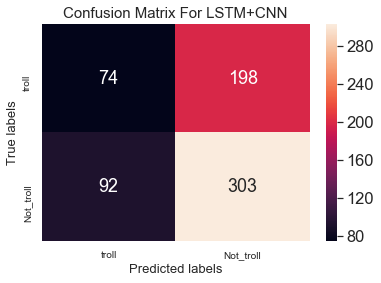

In [48]:

from sklearn.metrics import classification_report, confusion_matrix
import itertools

labels = ['troll', 'Not_troll']
cm = confusion_matrix(y_test, y_pred_txt)

ax= plt.subplot()
sns.set(font_scale=1.5) # Adjust to fit
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
label_font = {'size':'13'}  # Adjust to fit
ax.set_xlabel('Predicted labels',fontdict=label_font);
ax.set_ylabel('True labels',fontdict=label_font); 

title_font = {'size':'15'}  # Adjust to fit

ax.set_title('Confusion Matrix For LSTM+CNN',fontdict=title_font); 

ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit
ax.xaxis.set_ticklabels(['troll', 'Not_troll']); 
ax.yaxis.set_ticklabels(['troll', 'Not_troll']);

plt.savefig('D:\\My Research\\Shared Task Paper\\Troll\\Imagesconfusion_matrix_LSTM+CNN.jpg')  

In [49]:
print('Classification Report')
target_names = ['troll', 'Not_troll']
print(classification_report(y_test, y_pred_txt, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       troll       0.45      0.27      0.34       272
   Not_troll       0.60      0.77      0.68       395

   micro avg       0.57      0.57      0.57       667
   macro avg       0.53      0.52      0.51       667
weighted avg       0.54      0.57      0.54       667



In [112]:
# Define CNN architecture

embedding_dim = 100

model_cnn = Sequential()
model_cnn.add(keras.layers.Embedding(10000, embedding_dim, input_length=maxlen))
model_cnn.add(keras.layers.Conv1D(128, 5, activation='relu'))
model_cnn.add(keras.layers.GlobalMaxPooling1D())
model_cnn.add(keras.layers.Dense(10, activation='relu'))
model_cnn.add(keras.layers.Dense(1, activation='sigmoid'))
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print(model_cnn.summary())

# Fit model
# history = model_cnn.fit(x_train, y_train,
#                     epochs=5,
#                     verbose=True,
#                     validation_data=(x_test, y_test),
#                     batch_size=10)

history = model_cnn.fit(x_train, y_train, epochs=15, batch_size=32,verbose = 1 , validation_data=(x_val,y_val))


loss, accuracy = model.evaluate(x_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 1000, 100)         1000000   
                                                                 
 conv1d_3 (Conv1D)           (None, 996, 128)          64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,065,429
Trainable params: 1,065,429
Non-trainable params: 0
____________________________________________

In [117]:
#predicting the labels for the test set
y_pred_txt = (model_cnn.predict_generator(txt_gen_test, steps=667))
y_pred_txt_cnn = np.round(list(itertools.chain(*y_pred_txt)))

#y_pred_txt


C:\Users\maruf\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [119]:
print('Classification Report')
target_names = ['troll', 'Not_troll']
print(classification_report(y_test, y_pred_txt_cnn, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       troll       0.42      0.26      0.32       272
   Not_troll       0.60      0.74      0.66       395

   micro avg       0.55      0.55      0.55       667
   macro avg       0.51      0.50      0.49       667
weighted avg       0.52      0.55      0.52       667



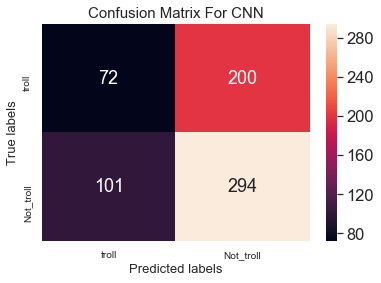

In [121]:

from sklearn.metrics import classification_report, confusion_matrix
import itertools

labels = ['troll', 'Not_troll']
cm = confusion_matrix(y_test, y_pred_txt)

ax= plt.subplot()
sns.set(font_scale=1.5) # Adjust to fit
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
label_font = {'size':'13'}  # Adjust to fit
ax.set_xlabel('Predicted labels',fontdict=label_font);
ax.set_ylabel('True labels',fontdict=label_font); 

title_font = {'size':'15'}  # Adjust to fit

ax.set_title('Confusion Matrix For CNN',fontdict=title_font); 

ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit
ax.xaxis.set_ticklabels(['troll', 'Not_troll']); 
ax.yaxis.set_ticklabels(['troll', 'Not_troll']);

plt.savefig('D:\\My Research\\Shared Task Paper\\Troll\\Imagesconfusion_matrix_CNN_text_f1_52.jpg')  

In [31]:
#Image Model


In [52]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["OMP_NUM_THREADS"] = "4"

In [53]:
from keras import regularizers

In [54]:
import keras
import tensorflow
from tensorflow.keras.applications.mobilenet import MobileNet

In [55]:
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation, Dropout

from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet, VGG16, xception, ResNet50
from keras.applications.mobilenet import preprocess_input
from keras.applications.vgg16 import preprocess_input
# from keras.applications.xception import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
from IPython.display import Image


In [56]:
#Importing all the libraries needed
import keras
import tensorflow
import h5py
from keras import optimizers, preprocessing, Input
from keras.models import load_model, Model
from keras.layers import Bidirectional
from keras.layers.core import Reshape, Dropout
from keras.utils.vis_utils import  plot_model
import os
import itertools
import matplotlib.pyplot as plt
from keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling3D
from keras import regularizers
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.applications.inception_v3 import InceptionV3
import nltk
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.layers import Dense, GlobalAveragePooling2D, Embedding, LSTM, multiply
from PIL import Image, ImageFile
from sklearn.model_selection import train_test_split

In [57]:
#model with adam optimizer
adam = tensorflow.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adadelta = tensorflow.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.9, epsilon=None, decay=0.0)

C:\Users\maruf\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [58]:
path_troll = os.path.realpath("D:\\My Research\\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\Troll_meme\\train\\troll")
path_NOT = os.path.realpath("D:\\My Research\\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\Troll_meme\\train\\Not_troll")

In [59]:
path_troll

'D:\\My Research\\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\Troll_meme\\train\\troll'

In [60]:
troll_img = os.listdir(path_troll)
dir_troll = [os.path.join(path_troll, filename) for filename in troll_img]
Not_troll_img = os.listdir(path_NOT)
dir_not = [os.path.join(path_NOT, filename) for filename in Not_troll_img]

In [61]:
print("# of troll images: ", len(troll_img), '\n',
      "# of not troll images: ", len(Not_troll_img))

# of troll images:  951 
 # of not troll images:  666


In [62]:

def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.vgg16.preprocess_input(img_array_expanded_dims)

In [63]:
def Image_model(base_model):
  #freezing all the trainable layers
  for layer in base_model.layers:
    layer.trainable = False
  #create output layer
  x = base_model.output
  #pooling layer before the output
  x = GlobalAveragePooling2D()(x)
  return x

In [64]:

pre_trained_image_model_vgg16 = VGG16(include_top=False, weights='D:\\My Research\\SHared Task\\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',input_shape=(224,224) + (3,))
base_model_loaded = Image_model(pre_trained_image_model_vgg16)
flatten_layer = Flatten()(base_model_loaded)
dropout_layer = Dropout(0.5)(flatten_layer)
image_pred_layer = Dense(1, activation='sigmoid')(dropout_layer)
image_only_model = Model(inputs = [pre_trained_image_model_vgg16.input], outputs = image_pred_layer)


In [65]:
for i,layer in enumerate(image_only_model.layers):
    print(i,layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_average_pooling2d
20 flatten
21 dropout
22 dense_4


In [66]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
test_generator=ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator=train_datagen.flow_from_directory('D:\\My Research\\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\Troll_meme\\train\\',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 shuffle=True)

valid_generator = test_generator.flow_from_directory('D:\\My Research\\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\Troll_meme\\test\\',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 shuffle=True)


# test_generator = test_generator.flow_from_directory('D:\\My Research\\SHared Task\\Troll Meme\\Tamil_troll_memes\\test_img\\',
#                                                  target_size=(224,224),
#                                                   color_mode='rgb',
#                                                   batch_size=1,
#                                                   class_mode='binary',
#                                                  shuffle=True)

Found 1617 images belonging to 2 classes.
Found 683 images belonging to 2 classes.


In [67]:
train_generator.classes

array([0, 0, 0, ..., 1, 1, 1])

In [68]:
np.unique(train_generator.classes)

array([0, 1])

In [69]:
# Addressing imbalanced data with class weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_generator.classes),
                                                 train_generator.classes)

In [19]:
class_weights

array([1.21396396, 0.85015773])

In [70]:
image_only_model.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
image_only_model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=7)

C:\Users\maruf\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/7
50/50 [==============================] - 527s 11s/step - loss: 1.9257 - accuracy: 0.6479
Epoch 2/7
50/50 [==============================] - 533s 11s/step - loss: 1.3192 - accuracy: 0.7237
Epoch 3/7
50/50 [==============================] - 519s 10s/step - loss: 1.0566 - accuracy: 0.7565
Epoch 4/7
50/50 [==============================] - 547s 11s/step - loss: 0.9292 - accuracy: 0.7861
Epoch 5/7
50/50 [==============================] - 544s 11s/step - loss: 0.7915 - accuracy: 0.8013
Epoch 6/7
50/50 [==============================] - 507s 10s/step - loss: 0.6698 - accuracy: 0.8158
Epoch 7/7
50/50 [==============================] - 548s 11s/step - loss: 0.6354 - accuracy: 0.8164


In [73]:
test_generator=ImageDataGenerator(preprocessing_function=preprocess_input)


test_generator = test_generator.flow_from_directory('D:\\My Research\\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\Troll_meme\\gold_label_test_img',
                                                 target_size=(224,224),
                                                  color_mode='rgb',
                                                  batch_size=1,
                                                  class_mode='binary',
                                                 shuffle=True)

Found 667 images belonging to 2 classes.


In [74]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

#Confution Matrix and Classification Report
Y_pred = image_only_model.predict_generator(test_generator, steps=667)
y_pred = np.round(list(itertools.chain(*Y_pred)))
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['troll', 'Not_troll']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

C:\Users\maruf\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


Confusion Matrix
[[ 31 241]
 [ 41 354]]
Classification Report
              precision    recall  f1-score   support

       troll       0.43      0.11      0.18       272
   Not_troll       0.59      0.90      0.72       395

   micro avg       0.58      0.58      0.58       667
   macro avg       0.51      0.51      0.45       667
weighted avg       0.53      0.58      0.50       667



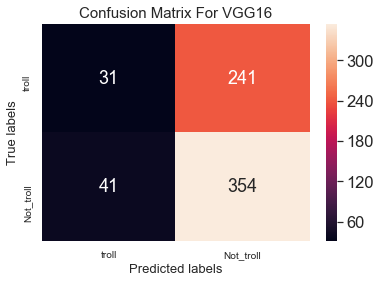

In [75]:

from sklearn.metrics import classification_report, confusion_matrix
import itertools

labels = ['troll', 'Not_troll']
cm = confusion_matrix(test_generator.classes, y_pred)

ax= plt.subplot()
sns.set(font_scale=1.5) # Adjust to fit
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
label_font = {'size':'13'}  # Adjust to fit
ax.set_xlabel('Predicted labels',fontdict=label_font);
ax.set_ylabel('True labels',fontdict=label_font); 

title_font = {'size':'15'}  # Adjust to fit

ax.set_title('Confusion Matrix For VGG16',fontdict=title_font); 

ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit
ax.xaxis.set_ticklabels(['troll', 'Not_troll']); 
ax.yaxis.set_ticklabels(['troll', 'Not_troll']);

plt.savefig('D:\\My Research\\Shared Task Paper\\Troll\\Images\\confusion_matrix_VGG16_f1_50.jpg')  

In [81]:
# Y_pred = [ int(x) for x in Y_pred ]

In [82]:
# only_text_df = pd.read_csv('D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\submit1.csv')

In [83]:
# count = 0;
# for i in y_pred_txt:
#     if i == 0:
#       only_text_df['label'][count] = "troll";
#     else:
#         only_text_df['label'][count] = "not_troll";
#     count = count + 1;
# count

663

In [84]:
# only_text_df.to_csv('D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\my_submit1_img_vgg16.csv', index = 'false')

In [76]:
def create_img_array(img_dirct):
    all_imgs = []
    for root, j, files in os.walk(img_dirct):
        for file in files:
            file = root + '/' + file
            all_imgs.append(file)
    return all_imgs

def create_img_path(DF, Col_name, img_dir):
    img_path = [img_dir + '/' + name for name in DF[Col_name]]
    return img_path

In [77]:
# Processing image 
img_dir = "D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\uploaded_tamil_memes"

img_dir_test = "D:\\My Research\\SHared Task\\Troll Meme\\Tamil_troll_memes\\test_img"

In [78]:
train_img_path = create_img_path(training_df,'image_name', img_dir)
test_img_path = create_img_path(testing_df,'image_name', img_dir_test)
val_img_path = create_img_path(validation_df,'image_name', img_dir)



In [79]:
def img_text_generator(files, padded_seq, y, batch_size=None):
    """
        padded_seq: vectorized padded text sequence 
        y: label of the text
        batch_size: Number of observations to be selected at a time
        
        return: generator object of text data
    """
    while True:
        batch_idxs = np.random.choice(a = list(range(len(padded_seq))), size=batch_size) #Selecting the random batch indexes    
        batch_input_txt = [] # Initializing batch input text
        batch_input_img = [] # Initializing batch input image
        batch_output = [] # Initializing batch output
        
        # Traversing through the batch indexes
        for batch_idx in batch_idxs:
            input_txt = padded_seq[batch_idx] # selecting padded sequences from the batch
            output = y[batch_idx] # Selecting label  
            input_img = get_input(files[batch_idx])
            input_img = process_input(input_img)
            batch_input_txt.append(input_txt) # Appending the input (text vector)
            batch_input_img.append(input_img[0])
            batch_output.append(output) # Appending the label
        
        # Return a tuple of (input,output) to feed the network
        batch_x1 = np.array( batch_input_img )
        batch_x2 = np.array( batch_input_txt )
        batch_y = np.array( batch_output )
        yield ([batch_x1, batch_x2], batch_y)

In [80]:

# Creating train, test, val, generator for meme
img_txt_gen_train = img_text_generator(train_img_path, x_train, y_train, batch_size=32)
img_txt_gen_test = img_text_generator(test_img_path, x_test, y_test, batch_size=1)
img_txt_gen_val = img_text_generator(val_img_path, x_val, y_val, batch_size=1)

In [90]:
#Multimodal using LSTM + VGG16

In [81]:
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f1_m])
image_only_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f1_m])

In [82]:
#concatenating the output of both the classifiers(text and image)
con_layer = keras.layers.concatenate([model.output, image_only_model.output])
out = Dense(1, activation='sigmoid')(con_layer)

In [83]:
#Common Model
com_model = Model(inputs = [image_only_model.input, model.input], outputs=out)

In [85]:

com_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [86]:
#Training the combined model
model3 = com_model.fit_generator(img_txt_gen_train, epochs=10, validation_steps = 683, steps_per_epoch=50, validation_data=img_txt_gen_val, shuffle=False)

C:\Users\maruf\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
50/50 [==============================] - 1281s 26s/step - loss: 0.6585 - accuracy: 0.5881 - val_loss: 0.6621 - val_accuracy: 0.4758
Epoch 2/10
50/50 [==============================] - 1321s 27s/step - loss: 0.6109 - accuracy: 0.5938 - val_loss: 0.6359 - val_accuracy: 0.5124
Epoch 3/10
50/50 [==============================] - 1241s 25s/step - loss: 0.5839 - accuracy: 0.5831 - val_loss: 0.6317 - val_accuracy: 0.4700
Epoch 4/10
50/50 [==============================] - 1183s 24s/step - loss: 0.5574 - accuracy: 0.6006 - val_loss: 0.6197 - val_accuracy: 0.4832
Epoch 5/10
50/50 [==============================] - 1217s 25s/step - loss: 0.5413 - accuracy: 0.5906 - val_loss: 0.5940 - val_accuracy: 0.4861
Epoch 6/10
50/50 [==============================] - 1419s 29s/step - loss: 0.5194 - accuracy: 0.6000 - val_loss: 0.5865 - val_accuracy: 0.4919
Epoch 7/10
50/50 [==============================] - 1376s 28s/step - loss: 0.5161 - accuracy: 0.5788 - val_loss: 0.5911 - val_accuracy: 0.6354

In [87]:

com_model.save('D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\LSTM_VGG16_Multimodl_model.h5')   # Saving model

In [88]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

#Confution Matrix and Classification Report
Y_pred = com_model.predict_generator(img_txt_gen_test, steps=667)
y_pred_com = np.round(list(itertools.chain(*Y_pred)))

#Y_pred = [ int(x) for x in Y_pred ]


C:\Users\maruf\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


In [91]:
print('Classification Report')
target_names = ['troll', 'Not_troll']
print(classification_report(y_test, y_pred_com, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       troll       0.22      0.01      0.01       272
   Not_troll       0.59      0.98      0.74       395

   micro avg       0.58      0.58      0.58       667
   macro avg       0.41      0.49      0.38       667
weighted avg       0.44      0.58      0.44       667



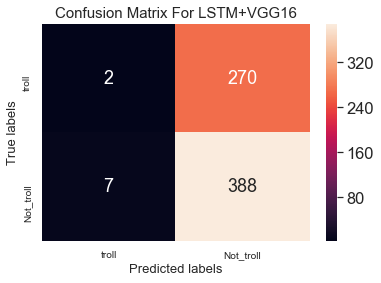

In [93]:

from sklearn.metrics import classification_report, confusion_matrix
import itertools

labels = ['troll', 'Not_troll']
cm = confusion_matrix(y_test, y_pred_com)

ax= plt.subplot()
sns.set(font_scale=1.5) # Adjust to fit
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
label_font = {'size':'13'}  # Adjust to fit
ax.set_xlabel('Predicted labels',fontdict=label_font);
ax.set_ylabel('True labels',fontdict=label_font); 

title_font = {'size':'15'}  # Adjust to fit

ax.set_title('Confusion Matrix For LSTM+VGG16',fontdict=title_font); 

ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit
ax.xaxis.set_ticklabels(['troll', 'Not_troll']); 
ax.yaxis.set_ticklabels(['troll', 'Not_troll']);

plt.savefig('D:\\My Research\\Shared Task Paper\\Troll\\Images\\confusion_matrix_LSTM+VGG16_f1_44.jpg')  

In [98]:
# only_text_df = pd.read_csv('D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\submit1.csv')

# count = 0;
# for i in y_pred_txt:
#     if i == 0:
#       only_text_df['label'][count] = "troll";
#     else:
#         only_text_df['label'][count] = "not_troll";
#     count = count + 1;
# print(count);

# only_text_df.to_csv('D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\my_submit1_combined.csv', index = 'false')

663


In [94]:
#Evaluating combined model by calculating loss and accuracy using test file
com_model.evaluate_generator(img_txt_gen_test, steps=667)

C:\Users\maruf\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[0.6993389129638672, 0.6003016829490662]

In [ ]:
#plotting validation accuracy
plt.plot(model3.history['val_f1_m'],'g')
plt.plot(model1.history['val_f1_m'],'b')
plt.plot(model2.history['val_f1_m'],'r')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.gca().legend(('meme model f1-score', 'text model f1-score', 'image model f1-score'))
plt.show()

In [ ]:
#Multimodal using LSTM + CNN + VGG16

In [95]:
model1.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f1_m])
image_only_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f1_m])

In [96]:
#concatenating the output of both the classifiers(text and image)
con_layer = keras.layers.concatenate([model.output, image_only_model.output])
out = Dense(1, activation='sigmoid')(con_layer)

In [97]:
#Common Model
com_model_1 = Model(inputs = [image_only_model.input, model.input], outputs=out)

In [98]:

com_model_1.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [99]:
#Training the combined model
model_1_combined = com_model_1.fit_generator(img_txt_gen_train, epochs=10, validation_steps = 683, steps_per_epoch=50, validation_data=img_txt_gen_val, shuffle=False)

C:\Users\maruf\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
50/50 [==============================] - 1263s 25s/step - loss: 0.4559 - accuracy: 0.8669 - val_loss: 0.4869 - val_accuracy: 0.8873
Epoch 2/10
50/50 [==============================] - 1219s 25s/step - loss: 0.4311 - accuracy: 0.9237 - val_loss: 0.4602 - val_accuracy: 0.8960
Epoch 3/10
50/50 [==============================] - 1267s 26s/step - loss: 0.3819 - accuracy: 0.9406 - val_loss: 0.4363 - val_accuracy: 0.8946
Epoch 4/10
50/50 [==============================] - 1285s 26s/step - loss: 0.3760 - accuracy: 0.9269 - val_loss: 0.4393 - val_accuracy: 0.8712
Epoch 5/10
50/50 [==============================] - 1347s 27s/step - loss: 0.3547 - accuracy: 0.9394 - val_loss: 0.4264 - val_accuracy: 0.8902
Epoch 6/10
50/50 [==============================] - 1388s 28s/step - loss: 0.3514 - accuracy: 0.9294 - val_loss: 0.4265 - val_accuracy: 0.8829
Epoch 7/10
50/50 [==============================] - 1431s 29s/step - loss: 0.3281 - accuracy: 0.9450 - val_loss: 0.4000 - val_accuracy: 0.8755

In [106]:

com_model_1.save('D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\CNN_LSTM_VGG16_Multimodl_model_1.h5')   # Saving model

In [114]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

#Confution Matrix and Classification Report
Y_pred = com_model_1.predict_generator(img_txt_gen_test, steps=667)
y_pred_com = np.round(list(itertools.chain(*Y_pred)))

#Y_pred = [ int(x) for x in Y_pred ]

C:\Users\maruf\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


In [115]:
print('Classification Report')
target_names = ['troll', 'Not_troll']
print(classification_report(y_test, y_pred_com, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       troll       0.34      0.04      0.08       272
   Not_troll       0.59      0.94      0.72       395

   micro avg       0.58      0.58      0.58       667
   macro avg       0.47      0.49      0.40       667
weighted avg       0.49      0.58      0.46       667



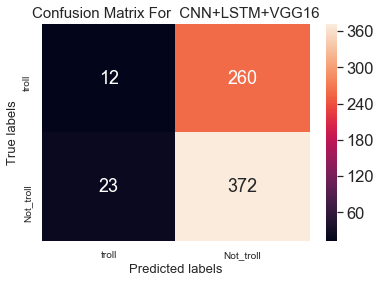

In [116]:

from sklearn.metrics import classification_report, confusion_matrix
import itertools

labels = ['troll', 'Not_troll']
cm = confusion_matrix(y_test, y_pred_com)

ax= plt.subplot()
sns.set(font_scale=1.5) # Adjust to fit
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
label_font = {'size':'13'}  # Adjust to fit
ax.set_xlabel('Predicted labels',fontdict=label_font);
ax.set_ylabel('True labels',fontdict=label_font); 

title_font = {'size':'15'}  # Adjust to fit

ax.set_title('Confusion Matrix For  CNN+LSTM+VGG16',fontdict=title_font); 

ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit
ax.xaxis.set_ticklabels(['troll', 'Not_troll']); 
ax.yaxis.set_ticklabels(['troll', 'Not_troll']);

plt.savefig('D:\\My Research\\Shared Task Paper\\Troll\\Images\\confusion_matrix_CNN_LSTM+VGG16_f1_46.jpg')  

In [ ]:
#CNN+Vgg16

In [122]:
model_cnn.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f1_m])
image_only_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f1_m])

In [123]:
#concatenating the output of both the classifiers(text and image)
con_layer = keras.layers.concatenate([model_cnn.output, image_only_model.output])
out = Dense(1, activation='sigmoid')(con_layer)

In [124]:
#Common Model
com_model_2 = Model(inputs = [image_only_model.input, model_cnn.input], outputs=out)

In [125]:

com_model_2.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [126]:
#Training the combined model
model_2_combined = com_model_2.fit_generator(img_txt_gen_train, epochs=10, validation_steps = 683, steps_per_epoch=50, validation_data=img_txt_gen_val, shuffle=False)

C:\Users\maruf\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
50/50 [==============================] - 730s 15s/step - loss: 0.4435 - accuracy: 0.9181 - val_loss: 0.5263 - val_accuracy: 0.9107
Epoch 2/10
50/50 [==============================] - 746s 15s/step - loss: 0.4011 - accuracy: 0.9488 - val_loss: 0.5248 - val_accuracy: 0.8755
Epoch 3/10
50/50 [==============================] - 713s 14s/step - loss: 0.3649 - accuracy: 0.9488 - val_loss: 0.4657 - val_accuracy: 0.9151
Epoch 4/10
50/50 [==============================] - 762s 15s/step - loss: 0.3497 - accuracy: 0.9525 - val_loss: 0.4809 - val_accuracy: 0.8697
Epoch 5/10
50/50 [==============================] - 764s 15s/step - loss: 0.3254 - accuracy: 0.9619 - val_loss: 0.4548 - val_accuracy: 0.8946
Epoch 6/10
50/50 [==============================] - 810s 16s/step - loss: 0.3077 - accuracy: 0.9556 - val_loss: 0.4474 - val_accuracy: 0.8785
Epoch 7/10
50/50 [==============================] - 743s 15s/step - loss: 0.2957 - accuracy: 0.9556 - val_loss: 0.4518 - val_accuracy: 0.8770
Epoch 

In [127]:

com_model_2.save('D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\CNN_LSTM_VGG16_Multimodl_model_2.h5')   # Saving model

In [128]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

#Confution Matrix and Classification Report
Y_pred = com_model_2.predict_generator(img_txt_gen_test, steps=667)
y_pred_com_2 = np.round(list(itertools.chain(*Y_pred)))

#Y_pred = [ int(x) for x in Y_pred ]


C:\Users\maruf\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


In [129]:
print('Classification Report')
target_names = ['troll', 'Not_troll']
print(classification_report(y_test, y_pred_com_2, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       troll       0.49      0.08      0.13       272
   Not_troll       0.60      0.94      0.73       395

   micro avg       0.59      0.59      0.59       667
   macro avg       0.54      0.51      0.43       667
weighted avg       0.55      0.59      0.49       667



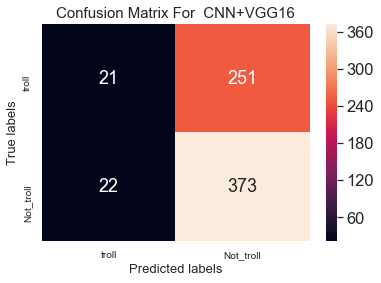

In [131]:

from sklearn.metrics import classification_report, confusion_matrix
import itertools

labels = ['troll', 'Not_troll']
cm = confusion_matrix(y_test, y_pred_com_2)

ax= plt.subplot()
sns.set(font_scale=1.5) # Adjust to fit
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
label_font = {'size':'13'}  # Adjust to fit
ax.set_xlabel('Predicted labels',fontdict=label_font);
ax.set_ylabel('True labels',fontdict=label_font); 

title_font = {'size':'15'}  # Adjust to fit

ax.set_title('Confusion Matrix For  CNN+VGG16',fontdict=title_font); 

ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit
ax.xaxis.set_ticklabels(['troll', 'Not_troll']); 
ax.yaxis.set_ticklabels(['troll', 'Not_troll']);

plt.savefig('D:\\My Research\\Shared Task Paper\\Troll\\Images\\confusion_matrix_CNN+VGG16_f1_49.jpg')  